In [4]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
import os
import pickle
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

In [5]:
DATA_DIR = './data/'

### Hyperparams

In [20]:
# output directory name:
output_dir = 'model_output/rnn'

# training:
epochs = 16 
batch_size = 128
training_size = 10**5

# vector-space embedding: 
n_dim = 32 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# RNN layer architecture:
n_rnn = 256 
drop_rnn = 0.2


# dense layer architecture: 
# n_dense = 256
# dropout = 0.2

### Load Data

In [3]:
# html = urllib3.PoolManager()
# resp = html.request('GET', 'https://github.com/dwyl/english-words/blob/master/words.txt?raw=true')

# eng_words = resp.data.decode('utf-8').split('\n')
# eng_words[:10]

In [6]:
with open(DATA_DIR + 'english_words.pk', 'rb') as foo:
    eng_words = pickle.load(foo)

In [7]:
eng_words[-10:]

['Zwinglianist',
 'zwitter',
 'zwitterion',
 'zwitterionic',
 'Zwolle',
 'Zworykin',
 'ZZ',
 'zZt',
 'ZZZ',
 '']

In [8]:
# resp1 = html.request('GET', 'https://github.com/napolux/paroleitaliane/blob/master/paroleitaliane/660000_parole_italiane.txt?raw=true')

# it_words = resp1.data.decode('utf-8').split('\n')
# it_words[:10]

In [10]:
with open(os.path.join(DATA_DIR, 'italian_words.pk'), 'rb') as foo:
    it_words = pickle.load(foo)

In [11]:
it_words[-10:]

['zwinglianesimo',
 'zwingliani',
 'zwingliano',
 'zwinglismi',
 'zwinglismo',
 'zwinglista',
 'zwingliste',
 'zwinglisti',
 'zzz',
 '']

In [12]:
## get character dictionary

eng_ch_vocab = set([c for w in eng_words for c in w])
it_ch_vocab = set([c for w in it_words for c in w])

vocab = sorted(list(eng_ch_vocab.union(it_ch_vocab)))
vocab

['!',
 '&',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [37]:
import json

with open('./data/vocab.json', 'w') as foow:
    json.dump(vocab, foow)

In [13]:
def convert_word_to_letter_id(w):
    out = [vocab.index(c) for c in w]
    return out

def convert_dataset_to_idx(words, maxlen=None):
    ids = [convert_word_to_letter_id(w) for w in words]
    out = pad_sequences(ids, maxlen=maxlen)
    return out


In [14]:
convert_word_to_letter_id('abaco')

[43, 44, 43, 45, 57]

### make dataset

In [30]:
max_len_word = max(max([len(w) for w in it_words]), max([len(w) for w in eng_words]))

it_words_ids = convert_dataset_to_idx(it_words, max_len_word)
eng_words_ids = convert_dataset_to_idx(eng_words, max_len_word)

X = np.r_[it_words_ids, eng_words_ids]
X, max_len_word


(array([[ 0,  0,  0, ..., 43, 45, 43],
        [ 0,  0,  0, ..., 45, 50, 51],
        [ 0,  0,  0, ..., 61, 62, 43],
        ...,
        [ 0,  0,  0, ..., 68, 42, 62],
        [ 0,  0,  0, ..., 42, 42, 42],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32), 45)

In [16]:
y = np.array([0]*len(it_words) + [1]*len(eng_words))
y

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
## shuffle
rs = np.random.RandomState(123)

ids_p = rs.permutation(range(len(y)))

X = X[ids_p, :]
y = y[ids_p]

n_train = int(len(y)*.75)

X_tr = X[:n_train, :]
X_te = X[n_train:, :]
y_tr = y[:n_train]
y_te = y[n_train:]


In [18]:
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape, y_tr.mean(), y_te.mean())

(846087, 45) (282029, 45) (846087,) (282029,) 0.41369859127962016 0.41317382255016327


### Fit model

In [16]:
model = load_model(output_dir+"/weights-1.01.hdf5")

In [21]:
model = Sequential()

embedding = Embedding(len(vocab), n_dim, input_length=max_len_word, mask_zero=True)

model.add(embedding) 
model.add(SpatialDropout1D(drop_embed))
model.add(LSTM(n_rnn, dropout=drop_rnn))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 32)            2208      
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 45, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 298,401
Trainable params: 298,401
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [26]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights-2.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [29]:
model.fit(X_tr, y_tr, batch_size=batch_size, epochs=1, 
          verbose=1, validation_data=(X_te, y_te), callbacks=[modelcheckpoint])

Train on 846087 samples, validate on 282029 samples
Epoch 1/1
166400/846087 [====>.........................] - ETA: 16:08 - loss: 0.1017 - acc: 0.9642

KeyboardInterrupt: 

In [17]:
def get_prediction_for_word(mod, w):
    ids = convert_word_to_letter_id(w)
    x = pad_sequences([ids], max_len_word)
    p = mod.predict_proba(x.reshape((1, max_len_word)))
    return p

In [18]:
get_prediction_for_word(model, 'cute')

array([[0.36486107]], dtype=float32)

In [19]:
def get_prediction_for_words(mod, W):
    idss = [convert_word_to_letter_id(w) for w in W]
    xx = pad_sequences(idss, max_len_word)
    p = mod.predict_proba(xx)
    return p

In [20]:
get_prediction_for_words(model, it_words[:10])

D:\Programs\Anaconda\envs\tensorflow-sandbox\lib\site-packages\keras\engine\sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


array([[ 0.265057  ],
       [-0.09119616],
       [ 0.04656781],
       [ 0.28953287],
       [-0.3117346 ],
       [-0.27043155],
       [ 0.00383865],
       [ 0.266654  ],
       [ 0.5415539 ],
       [ 0.6926975 ]], dtype=float32)

In [21]:
import pandas as pd

In [22]:
%%time

ssize = 100000

sswords = np.random.choice(list(set(it_words).difference(eng_words)), ssize, replace=False)

df_ita = pd.DataFrame({'word':sswords})
df_ita['pred'] = get_prediction_for_words(model, df_ita['word'].values)

Wall time: 47.5 s


D:\Programs\Anaconda\envs\tensorflow-sandbox\lib\site-packages\keras\engine\sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


In [23]:
# top n parole italiane che suonano inglesi

df_ita.sort_values('pred', ascending=False).head(20)

,word,pred
41509,catalloy,0.999700
64971,speedway,0.999695
26382,joypad,0.999683
2111,hydrospeed,0.999570
37814,yurty,0.999389
20489,canyon,0.999189
77655,friendly,0.999070
90356,ryton,0.999065
16148,wallaby,0.999018
36131,cosplay,0.998963


In [24]:
## top n parole che suonano italiane

df_ita.sort_values('pred').head(20)

,word,pred
79032,sassafrasso,-0.709151
46192,circonstanziero,-0.708358
38499,sguinzagliero,-0.703697
70593,fidecommisso,-0.702689
71936,differenziero,-0.702478
35456,surcompresso,-0.702110
68163,ricetrasmesso,-0.701474
50204,scandagliero,-0.701235
81514,rigermogliero,-0.701039
24022,contraffosso,-0.699609


In [25]:
%%time

ssize = 10000

sswords = np.random.choice(list(set(eng_words).difference(it_words)), ssize, replace=False)

df_eng = pd.DataFrame({'word':sswords})
df_eng['pred'] = get_prediction_for_words(model, df_eng['word'].values)

Wall time: 4.85 s


D:\Programs\Anaconda\envs\tensorflow-sandbox\lib\site-packages\keras\engine\sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


In [26]:
# top 20 english words that sound italian

df_eng.sort_values('pred').head(20)

,word,pred
855,arriero,-0.620410
1024,psilatro,-0.615324
324,solariego,-0.556191
1885,counterembargo,-0.545927
7937,susso,-0.525332
6598,sermonettino,-0.514565
721,zaburro,-0.505237
3011,zorrillo,-0.503622
9857,overgo,-0.482432
4457,cururo,-0.461673


In [27]:
# top 20 english words that sound very english

df_eng.sort_values('pred', ascending=False).head(20)

,word,pred
9288,do.,0.999972
3338,B.D.,0.999969
4940,D.S.M.,0.999968
31,Q.,0.999954
3374,q.e.,0.999946
4886,simplicity's,0.999941
749,liability's,0.999935
1398,lily's,0.999931
6890,freq.,0.999930
2807,Cryptorhynchus,0.999928


In [28]:
get_prediction_for_word(model, 'pappero')

D:\Programs\Anaconda\envs\tensorflow-sandbox\lib\site-packages\keras\engine\sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


array([[-0.4148296]], dtype=float32)

In [29]:
get_prediction_for_word(model, 'supercalifragilisticexpialidocious')

array([[0.9980908]], dtype=float32)

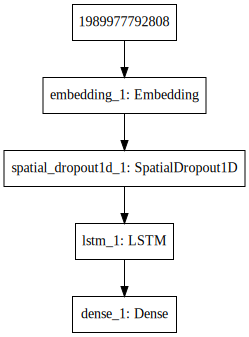

In [32]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model

def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
visualize_model(model)

In [33]:
plot_model(model, to_file='model.png')

### Access embedding layer

In [37]:
e = model.get_layer('embedding_1')

In [45]:
e.get_weights()[0].shape

(69, 32)